<a href="https://colab.research.google.com/github/mmasdar/end-to-end-dental-disease/blob/main/Inference_All_Model_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

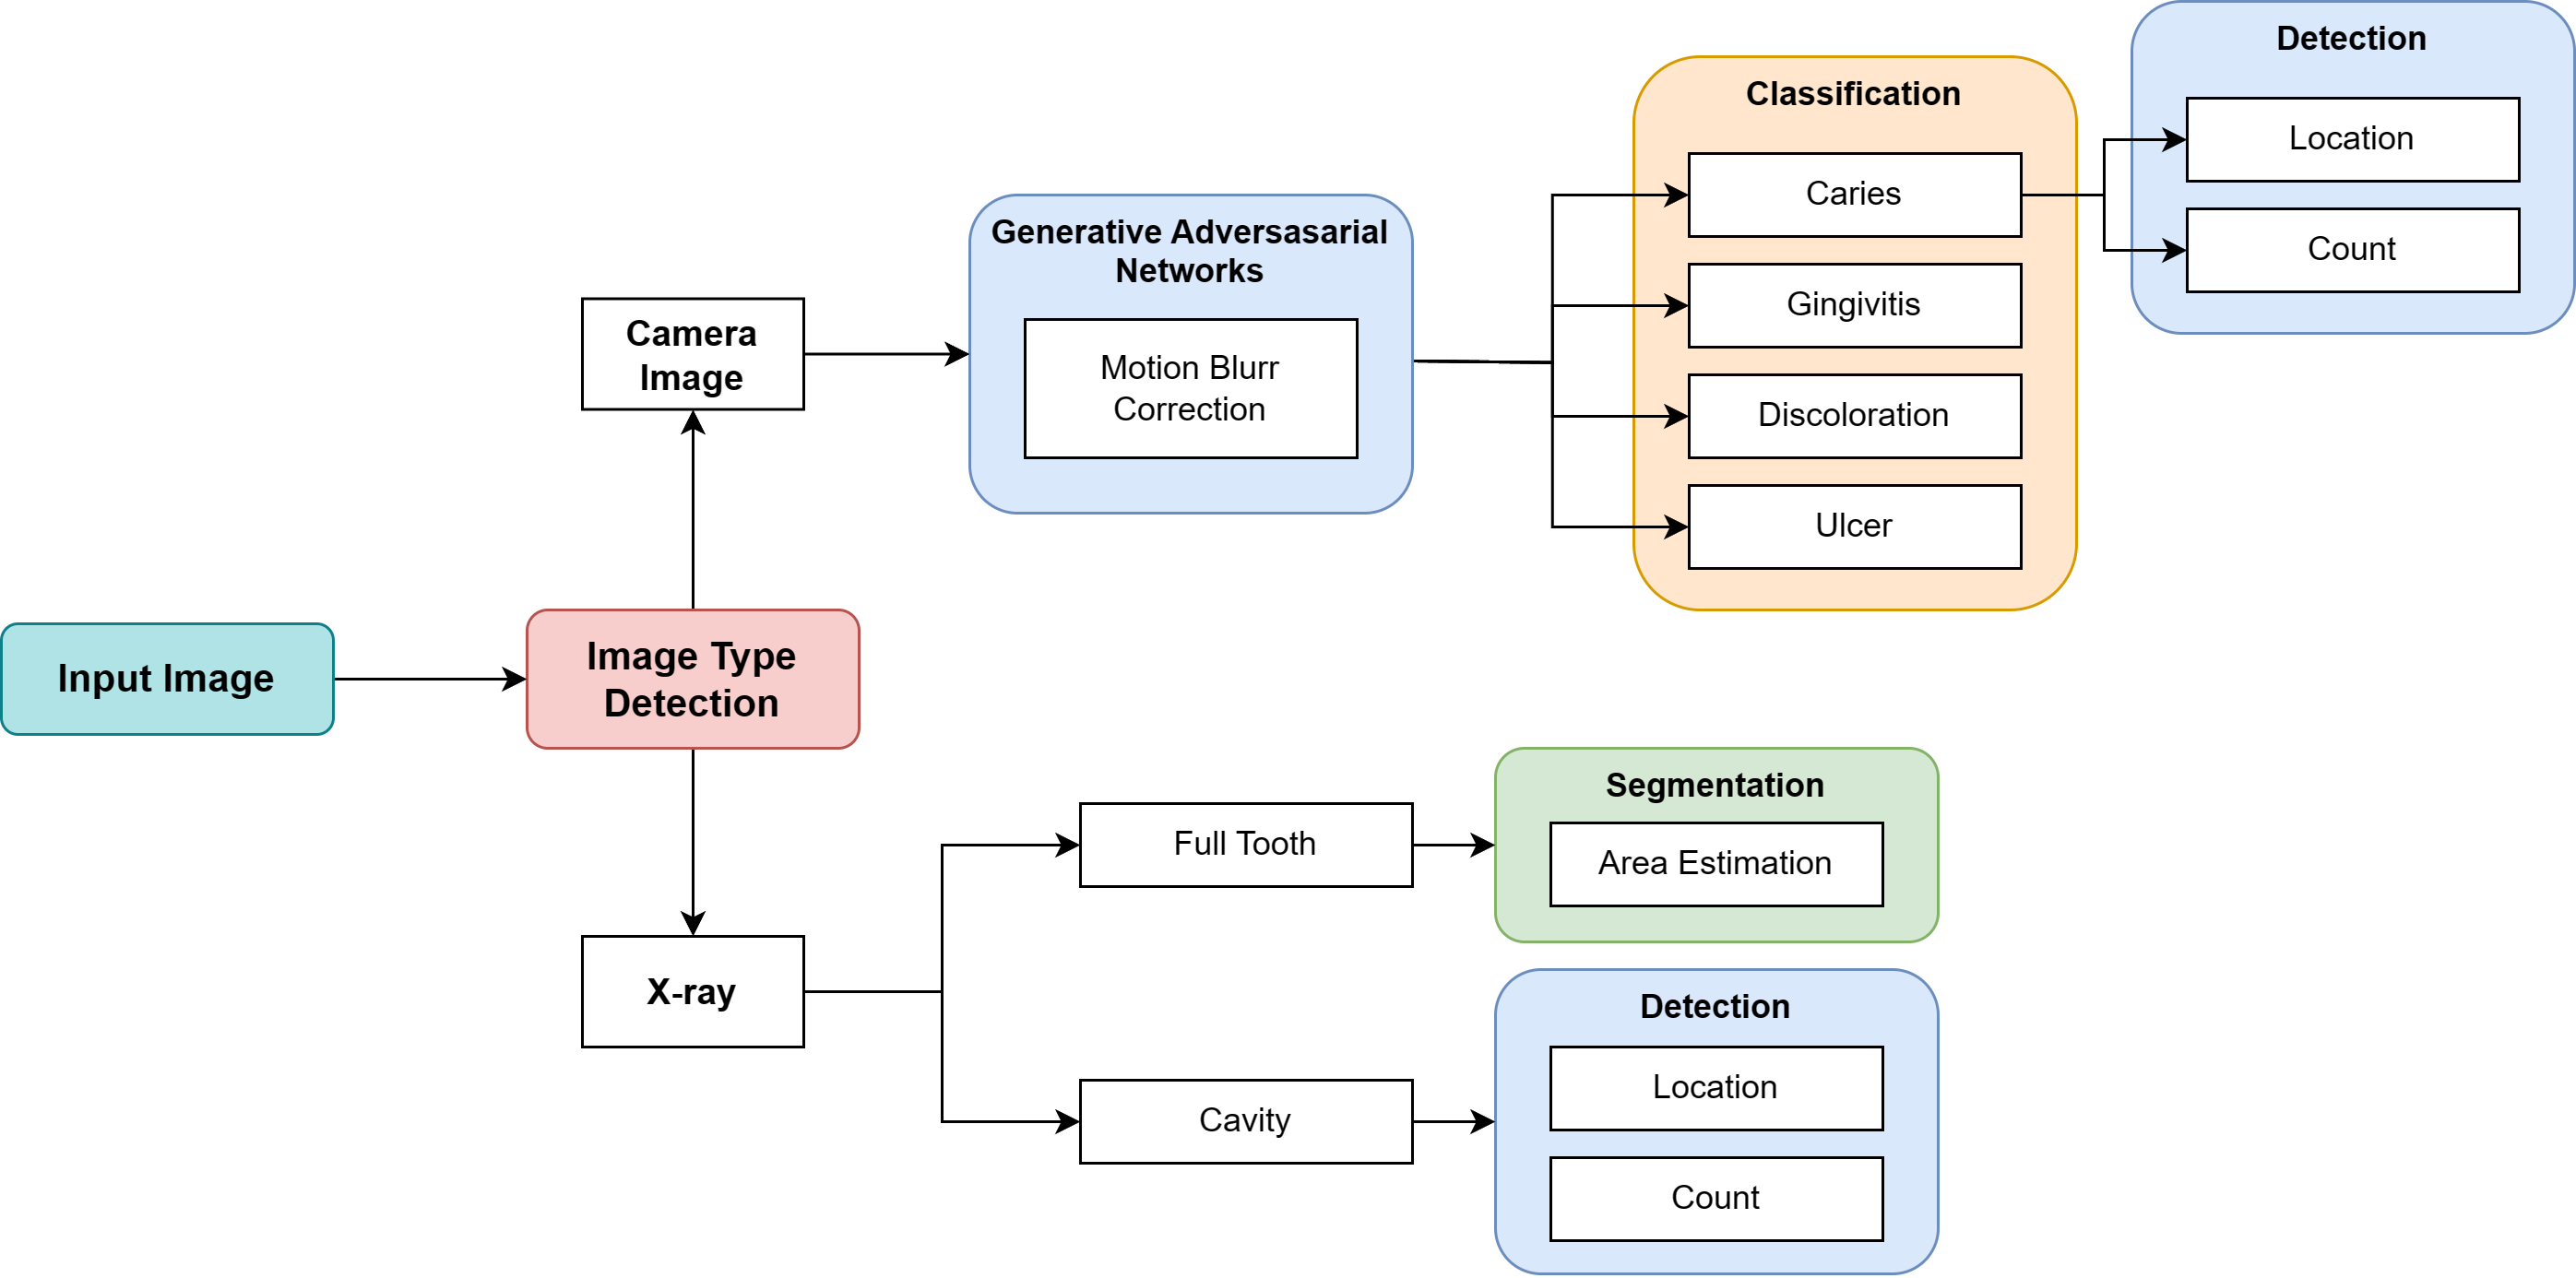

In [1]:
# Mounting model

# Mounting Dataset
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
# model Generative Adversarial Networks for Camera Dental Images with Blurr Motion
# in progress for SR-GAN Optimum Model
#model_1 = 

# model image classification for Camera Dental Images
model_2 = '/content/gdrive/MyDrive/Dental Disease/Trained Model/classification-camera-5class/dental_v1_vgg16.h5'

# model image Detection for Camera Dental Images
model_3 = '/content/gdrive/MyDrive/Dental Disease/Trained Model/detection-camera-cavity/train/weights/best.pt'

# model image Detection for X-ray Dental Images
model_4 = '/content/gdrive/MyDrive/Dental Disease/Trained Model/detection-xray-cavity/train/run2/weights/best.pt'

# model image Segmentation for X-ray Dental Images
model_5 = '/content/gdrive/MyDrive/Dental Disease/Trained Model/segmentation-xray-all tooth/dental_unet_RFB_3_conv_layers.h5'

In [4]:
import torch
import torchvision.models as models
from tensorflow.keras.models import load_model

def print_model_structure(model, model_type):
    if model_type == 'h5':
        if isinstance(model, str):
            model = load_model(model)
        model.summary()
    elif model_type == 'pt':
        if isinstance(model, str):
            model = torch.load(model)
        print(model)
    else:
        print("Invalid model type. Please provide 'h5' or 'pt'.")

# Example usage
print_model_structure(model_2, 'h5')

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

## Pre-Processing Selection:
### X-ray and Camera Dental Image Detection

In [ ]:
import cv2

def is_grayscale(image):
    # Take the average value in each channel
    b, g, r = cv2.split(image)
    avg_b = b.mean()
    avg_g = g.mean()
    avg_r = r.mean()
    
    # Check the average value in each channel
    if avg_b == avg_g == avg_r:
        return True
    else:
        return False

# Import Image
image = cv2.imread('/content/49.jpg')

# check the images x-ray or not
if is_grayscale(image):
    print("This is X-ray image")
else:
    print("This is Color Image from Camera")

This is Color Image from Camera


## Model 1 :
### Motion Blurr Correction using SR-GANs

#### Make Function to generate motion blurr

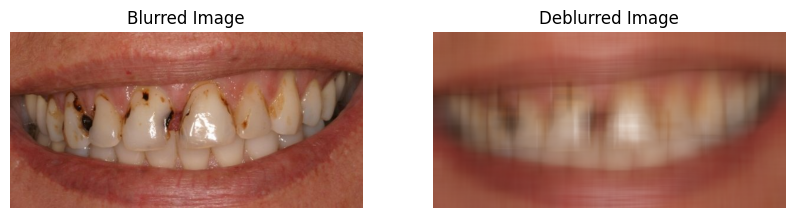

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def motion_deblur(image, kernel_size):
    # Create the vertical kernel.
    kernel_v = np.zeros((kernel_size, kernel_size))
    # Create a copy of the same for creating the horizontal kernel.
    kernel_h = np.copy(kernel_v)
    # Fill the middle row with ones.
    kernel_v[:, int((kernel_size - 1)/2)] = np.ones(kernel_size)
    kernel_h[int((kernel_size - 1)/2), :] = np.ones(kernel_size)
    # Normalize.
    kernel_v /= kernel_size
    kernel_h /= kernel_size

    # Perform deconvolution using the vertical kernel.
    deblurred_v = cv2.filter2D(image, -1, kernel_v)
    # Perform deconvolution using the horizontal kernel.
    deblurred_h = cv2.filter2D(image, -1, kernel_h)

    # Combine the deconvolved images.
    deblurred = cv2.addWeighted(deblurred_v, 0.5, deblurred_h, 0.5, 0)

    return deblurred

# Load the blurred image
blurred_image = cv2.imread('/content/70.jpg')

# Specify the kernel size used for blurring (should be the same as the original motion blur)
kernel_size = 50

# Perform motion deblurring
deblurred_image = motion_deblur(blurred_image, kernel_size)

# Display the original blurred image
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(blurred_image, cv2.COLOR_BGR2RGB))
plt.title('Blurred Image')
plt.axis('off')

# Display the deblurred image
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(deblurred_image, cv2.COLOR_BGR2RGB))
plt.title('Deblurred Image')
plt.axis('off')

plt.show()

#### Inference for SR-GAN Model

## Model 2 :
### Classification for Dental Disease

In [ ]:
import numpy as np
from keras.models import load_model
import tensorflow as tf
from PIL import Image

def classify_image(image_path):
    # Load the model
    model = model_2
    model = tf.keras.models.load_model(model)

    # Load and preprocess the image
    img = Image.open(image_path)
    img = img.resize((256, 256))  # Resize the image to match the input size of the model
    img = np.array(img)
    img = np.expand_dims(img, axis=0)
    img = img / 255.0

    # Make predictions
    predictions = model.predict(img)

    # Get the predicted class labels
    class_labels = ['Caries', 
                    'Gingivitis', 
                    'Discoloration', 
                    'Ulcer']

    # Print the predicted class probabilities
    for i, prob in enumerate(predictions[0]):
        label = class_labels[i]
        print(f"{label}: {prob * 100}%")

    # Get the predicted class index
    predicted_class_index = np.argmax(predictions)

    # Get the predicted class label
    predicted_class_label = class_labels[predicted_class_index]

    return predicted_class_label


image_path = '/content/47.jpg'

predicted_class = classify_image(image_path)
print("Predicted class:", predicted_class)

1/1 [==============================] - 1s 592ms/step
Caries: 70.12467980384827%
Gingivitis: 22.21631556749344%
Discoloration: 4.67146635055542%
Ulcer: 2.98753809183836%
Predicted class: Caries


## Model 3 :
### Camera Cavity Detection using YoLo v7

#### Open image and label

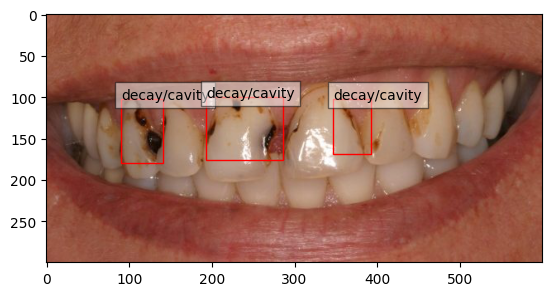

In [ ]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to your XML and JPEG files
xml_file_path = '/content/70.xml'
jpeg_file_path = '/content/70.jpg'


# Parse the XML file
tree = ET.parse(xml_file_path)
root = tree.getroot()

# Get the image file name
filename = root.find('.//filename').text

# Get the image size
width = int(root.find('.//width').text)
height = int(root.find('.//height').text)

# Display the image
image = mpimg.imread(jpeg_file_path)
plt.imshow(image)

# Draw bounding boxes for each object
for obj in root.findall('.//object'):
    name = obj.find('name').text
    xmin = int(obj.find('.//xmin').text)
    ymin = int(obj.find('.//ymin').text)
    xmax = int(obj.find('.//xmax').text)
    ymax = int(obj.find('.//ymax').text)
    
    # Draw the bounding box on the image
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, 
                                      linewidth=1, edgecolor='r', facecolor='none'))
    
    # Add label text
    plt.text(xmin, ymin, name, bbox=dict(facecolor='white', alpha=0.5))
    
# Show the image with the bounding boxes
plt.show()

In [ ]:
import torch
from torchvision import transforms
from PIL import Image

# Define your custom YoLo v7 model
class YoloV7(torch.nn.Module):
    def __init__(self):
        super(YoloV7, self).__init__()
        # Define the architecture of your YoLo v7 model here

    def forward(self, x):
        # Implement the forward pass of your YoLo v7 model here
        return x  # Modify this line to return the actual output of your model

# Load the saved model
model = YoloV7()
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Dental Disease/Trained Model/detection-camera-cavity/train/weights/best.pt'))
model.eval()

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as per your training data
])

# Load and preprocess the test image
image = Image.open('/content/70.jpg')
image = transform(image).unsqueeze(0)

# Forward pass
with torch.no_grad():
    output = model(image)

# Print the predicted bounding box coordinates and class labels
print(output)

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import torch.nn as nn

# Define your custom YoLo v7 model
class YoloV7(nn.Module):
    def __init__(self):
        super(YoloV7, self).__init__()
        # Define the architecture of your YoLo v7 model here
        # Example: self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding)

    def forward(self, x):
        # Implement the forward pass of your YoLo v7 model here
        # Example: x = self.conv1(x)
        return x  # Modify this line to return the actual output of your model

# Load the saved model
model = YoloV7()
model.load_state_dict(torch.load('/content/gdrive/MyDrive/Dental Disease/Trained Model/detection-xray-cavity/train/run2/weights/best.pt', map_location=torch.device('cpu')))
model.eval()

# Preprocess the image
transform = transforms.Compose([
    transforms.Resize((416, 416)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize as per your training data
])

# Load and preprocess the test image
image = Image.open('/content/6.jpg')
image = transform(image).unsqueeze(0)

# Forward pass
with torch.no_grad():
    output = model(image)

# Process the output
# Assuming your model returns bounding box coordinates and class predictions
# You can extract the information from 'output' variable as per your model's implementation

# Print the predicted bounding box coordinates and class labels
print(output)

# You can perform further processing or visualization of the predictions as per your requirement


ModuleNotFoundError: ignored

## Model 4 :
### X-ray Tooth Cavity Detection using YoLo v7

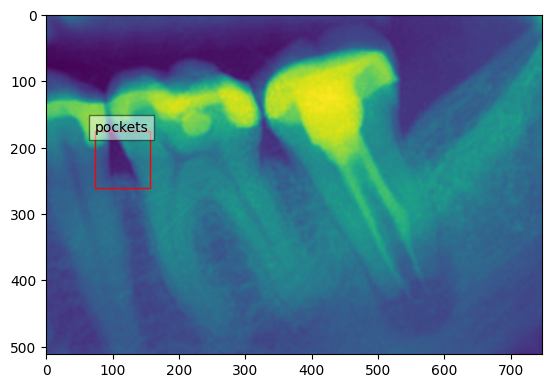

In [ ]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Path to your XML and JPEG files
xml_file_path = '/content/565.xml'
jpeg_file_path = '/content/565.jpg'

# Parse the XML file
tree = ET.parse(xml_file_path)
root = tree.getroot()

# Get the image size
size = root.find('.//size')
width = int(size.find('width').text)
height = int(size.find('height').text)

# Display the image
image = mpimg.imread(jpeg_file_path)
plt.imshow(image)

# Draw bounding boxes for each object
for obj in root.findall('.//object'):
    name = obj.find('name').text
    bndbox = obj.find('bndbox')
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    # Draw the bounding box on the image
    plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                      linewidth=1, edgecolor='r', facecolor='none'))

    # Add label text
    plt.text(xmin, ymin, name, bbox=dict(facecolor='white', alpha=0.5))

# Show the image with the bounding boxes
plt.show()

## Model 4 :
### X-ray Tooth Segmentation

1/1 [==============================] - 3s 3s/step


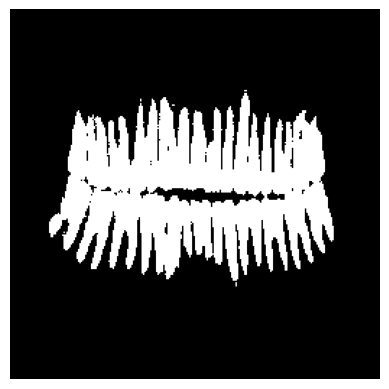

In [20]:
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt

def diceCoef(y_true, y_pred):   
    smooth = K.epsilon()
    y_true_f = K.flatten(y_true)    
    y_pred_f = K.flatten(y_pred)    
    intersection = K.sum(y_true_f * y_pred_f)    
    return (2. * intersection + smooth) / (K.sum(y_true_f*y_true_f) + K.sum(y_pred_f*y_pred_f) + smooth)

def diceCoefLoss(y_true, y_pred):
    return 1.0 - diceCoef(y_true, y_pred)

def bce_dice_loss(y_true, y_pred):
    loss = binary_crossentropy(y_true, y_pred) + diceCoefLoss(y_true, y_pred)
    return loss

# Register the custom loss and metric functions
custom_objects = {"bce_dice_loss": bce_dice_loss, "diceCoef": diceCoef}

# Load the segmentation model from .h5 file
model = load_model('/content/gdrive/MyDrive/Dental Disease/Trained Model/segmentation-xray-all tooth/dental_unet_RFB_3_conv_layers.h5', custom_objects=custom_objects)

# Function to perform segmentation on an input image
def segment_image(image_path):
    # Load and preprocess the input image
    img = Image.open(image_path)
    img = img.resize((256, 256))  # Resize to match model's input shape
    img = np.array(img)
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    img = img / 255.0  # Normalize pixel values (assuming range 0-255)

    # Perform segmentation
    seg_map = model.predict(img)
    seg_map = np.squeeze(seg_map)  # Remove batch dimension
    seg_map = np.argmax(seg_map, axis=-1)  # Get the class predictions

    return seg_map

# Example usage
input_image = '/content/cate2-00001.jpg'
segmentation_map = segment_image(input_image)

# Save the segmentation map as an image
output_image = Image.fromarray(segmentation_map.astype(np.uint8))
output_image.save('/content/output_565.jpg')

# Display the output segmented image
plt.imshow(output_image, 'gray')
plt.axis('off')
plt.show()